In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pi
import plotly.express as px
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

In [3]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [4]:
stock_data = pd.read_csv('data1.csv')
stock_data.head()

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率,收益率,波动率
0,2004-02-04,9.88,10.01,10.08,9.85,193975,193900992.0,2.34,1.83,0.18,1.38,0.004983,0.022486
1,2004-02-05,10.06,10.06,10.28,9.98,174839,176604992.0,3.00,0.50,0.05,1.24,0.043760,0.023390
2,2004-02-06,10.08,10.51,10.98,9.88,438125,459816992.0,10.93,4.47,0.45,3.11,0.007583,0.021607
3,2004-02-09,10.54,10.59,10.74,10.42,196300,207036992.0,3.04,0.76,0.08,1.39,0.014065,0.021653
4,2004-02-10,10.65,10.74,10.95,10.51,232602,249108992.0,4.15,1.42,0.15,1.65,-0.011236,0.022132


In [5]:
stock_data.describe().T

,count,mean,std,min,25%,50%,75%,max
开盘,4693.0,1.453420e+01,6.490971e+00,5.090000e+00,1.029000e+01,1.328000e+01,1.697000e+01,4.711000e+01
收盘,4693.0,1.454824e+01,6.489111e+00,5.100000e+00,1.029000e+01,1.329000e+01,1.698000e+01,4.805000e+01
最高,4693.0,1.479196e+01,6.665237e+00,5.230000e+00,1.041000e+01,1.350000e+01,1.724000e+01,4.898000e+01
最低,4693.0,1.430233e+01,6.322920e+00,5.050000e+00,1.017000e+01,1.308000e+01,1.668000e+01,4.701000e+01
成交量,4693.0,6.675073e+05,6.326273e+05,8.748000e+03,2.211390e+05,5.020870e+05,8.969010e+05,5.086050e+06
成交额,4693.0,9.625261e+08,9.449943e+08,6.962000e+06,3.357000e+08,6.932570e+08,1.283356e+09,8.596942e+09
振幅,4693.0,3.125250e+00,1.974286e+00,0.000000e+00,1.770000e+00,2.620000e+00,3.940000e+00,1.769000e+01
涨跌幅,4693.0,3.324952e-02,2.577503e+00,-4.189000e+01,-1.200000e+00,0.000000e+00,1.100000e+00,1.007000e+01
涨跌额,4693.0,-8.097166e-05,4.696381e-01,-8.060000e+00,-1.500000e-01,0.000000e+00,1.400000e-01,3.450000e+00
换手率,4693.0,9.193608e-01,8.069908e-01,6.000000e-02,4.100000e-01,6.400000e-01,1.160000e+00,8.400000e+00


In [6]:
maxv=1.366039e-01
minv=2.271468e-03

In [7]:
stock_data['日期'] = pd.to_datetime(stock_data['日期'])
stock_data = stock_data.sort_values('日期')
stock = stock_data[['日期', '收盘', '最高', '最低', '开盘', '波动率','换手率','振幅']]
stock

,日期,收盘,最高,最低,开盘,波动率,换手率,振幅
0,2004-02-04,10.01,10.08,9.85,9.88,0.022486,1.38,2.34
1,2004-02-05,10.06,10.28,9.98,10.06,0.023390,1.24,3.00
2,2004-02-06,10.51,10.98,9.88,10.08,0.021607,3.11,10.93
3,2004-02-09,10.59,10.74,10.42,10.54,0.021653,1.39,3.04
4,2004-02-10,10.74,10.95,10.51,10.65,0.022132,1.65,4.15
...,...,...,...,...,...,...,...,...
4688,2023-12-22,9.20,9.28,9.11,9.19,0.010233,0.52,1.85
4689,2023-12-25,9.19,9.20,9.14,9.18,0.010361,0.21,0.65
4690,2023-12-26,9.10,9.20,9.07,9.19,0.009946,0.28,1.41
4691,2023-12-27,9.12,9.13,9.02,9.10,0.013541,0.33,1.21


In [8]:
#normalization
scaler = MinMaxScaler()
normalized_data = stock[['振幅', '最高', '换手率', '收盘', '波动率']].copy()#['开盘', '最高', '最低', '成交量', '收盘']
normalized_data = scaler.fit_transform(normalized_data)

In [9]:
train_data, test_data = train_test_split(normalized_data, test_size=0.2, shuffle=False)
train_df = pd.DataFrame(train_data, columns=['振幅', '最高', '换手率', '收盘', '波动率'])
test_df = pd.DataFrame(test_data, columns=['振幅', '最高', '换手率', '收盘', '波动率'])#['开盘', '最高', '最低', '成交量', '收盘']

In [10]:
#actual: seqlen-1
def generate_sequences(df, seq_length=27):
    X = df[['振幅', '最高', '换手率', '收盘', '波动率']].reset_index(drop=True)
    y = df[['振幅', '最高', '换手率', '收盘', '波动率']].reset_index(drop=True)

    sequences = []
    labels = []

    for index in range(len(X) - seq_length):
        sequences.append(X.iloc[index : index + seq_length].values)
        labels.append(y.iloc[index + seq_length ].values)

    sequences = np.array(sequences)
    labels = np.array(labels)

    return sequences, labels


In [11]:
train_sequences, train_labels = generate_sequences(train_df)
test_sequences, test_labels = generate_sequences(test_df)

In [12]:
from keras.models import load_model

# 加载模型
model = load_model('my_model.h5')

In [13]:
import numpy as np

# 初始输入数据
input_data = np.expand_dims(test_sequences[-1], axis=0)  

# 循环预测未来十个时间步
predictions = []
for _ in range(11):
    # 进行预测
    prediction = model.predict(input_data)
    
    # 将预测值添加到predictions列表中
    predictions.append(prediction)
    
    # 更新输入数据，将新的预测值加入输入序列
    input_data = np.concatenate([input_data[:, 1:, :], np.expand_dims(prediction, axis=1)], axis=1)

# 将predictions列表转换为NumPy数组
predictions = np.array(predictions)

# 打印预测结果的形状
print(predictions.shape)  # 应该是 (11, 1, 5)，表示预测了11个时间步，每个时间步有一个样本，每个样本有5个预测值

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
(11, 1, 5)


In [14]:
future_predictions = predictions[:, :, -1]
future_predictions

array([[0.07610638],
       [0.08280192],
       [0.08254465],
       [0.08315403],
       [0.08223198],
       [0.0809075 ],
       [0.0789685 ],
       [0.07676172],
       [0.07444593],
       [0.07223041],
       [0.07022957]], dtype=float32)

In [15]:
#反归一化
future=[]
for i in future_predictions:
    temp = i*(maxv - minv) + minv
    future.append(temp)

future

[array([0.01249502], dtype=float32),
 array([0.01339445], dtype=float32),
 array([0.01335989], dtype=float32),
 array([0.01344175], dtype=float32),
 array([0.01331789], dtype=float32),
 array([0.01313997], dtype=float32),
 array([0.0128795], dtype=float32),
 array([0.01258306], dtype=float32),
 array([0.01227197], dtype=float32),
 array([0.01197435], dtype=float32),
 array([0.01170558], dtype=float32)]

In [16]:
future= future[1:]

In [17]:
model1 = load_model('baseline.h5')

In [18]:
import numpy as np

# 初始输入数据
input_data = np.expand_dims(test_sequences[-1], axis=0)  

# 循环预测未来十个时间步
predictions1 = []
for _ in range(11):
    # 进行预测
    prediction1 = model1.predict(input_data)
    
    # 将预测值添加到predictions列表中
    predictions1.append(prediction1)
    
    # 更新输入数据，将新的预测值加入输入序列
    input_data = np.concatenate([input_data[:, 1:, :], np.expand_dims(prediction1, axis=1)], axis=1)

# 将predictions列表转换为NumPy数组
predictions1 = np.array(predictions1)

# 打印预测结果的形状
print(predictions1.shape)  # 应该是 (11, 1, 5)，表示预测了11个时间步，每个时间步有一个样本，每个样本有5个预测值

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(11, 1, 5)


In [19]:
future_predictions1 = predictions1[:, :, -1]
future_predictions1

array([[0.08111549],
       [0.08016486],
       [0.07900588],
       [0.07703891],
       [0.07461759],
       [0.07201899],
       [0.0693735 ],
       [0.06676795],
       [0.06424843],
       [0.0617933 ],
       [0.05936119]], dtype=float32)

In [20]:
#反归一化
another=[]
for i in future_predictions1:
    temp = i*(maxv - minv) + minv
    another.append(temp)

another

[array([0.01316791], dtype=float32),
 array([0.01304021], dtype=float32),
 array([0.01288452], dtype=float32),
 array([0.01262029], dtype=float32),
 array([0.01229503], dtype=float32),
 array([0.01194595], dtype=float32),
 array([0.01159058], dtype=float32),
 array([0.01124057], dtype=float32),
 array([0.01090212], dtype=float32),
 array([0.01057231], dtype=float32),
 array([0.0102456], dtype=float32)]

In [21]:
another=another[1:]

In [22]:
another

[array([0.01304021], dtype=float32),
 array([0.01288452], dtype=float32),
 array([0.01262029], dtype=float32),
 array([0.01229503], dtype=float32),
 array([0.01194595], dtype=float32),
 array([0.01159058], dtype=float32),
 array([0.01124057], dtype=float32),
 array([0.01090212], dtype=float32),
 array([0.01057231], dtype=float32),
 array([0.0102456], dtype=float32)]

In [23]:
baseline=[0.01088023, 0.01088036, 0.01088036, 0.01088036, 0.01088036,
       0.01088036, 0.01088036, 0.01088036, 0.01088036, 0.01088036]  #ARIMA的预测值

In [24]:
#another=[0.01304021,0.01288452,0.01262029,0.01229503,0.01194595,
#         0.01159058,0.01124057,0.01090212,0.01057231,0.0102456] #baseline 的预测值


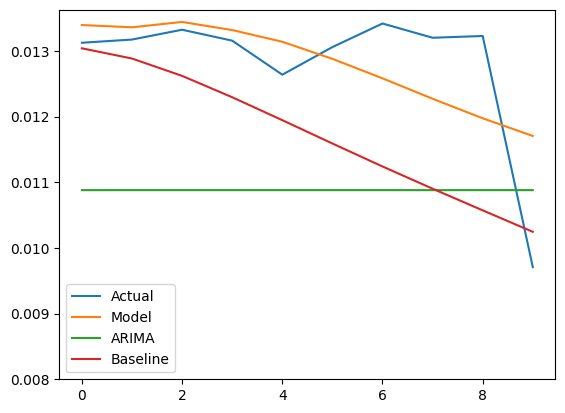

In [25]:
acdata = pd.read_csv('data333.csv')
acdata.tail(21)
acdatav=acdata.drop(acdata.tail(6).index)
acdatavv=acdatav.tail(10)
vdata=acdatavv['波动率'].tolist()
vdata1 = [element for element in vdata]  # 使用列表推导式将列列表转换为行列表
x=[]
for i in range(10):
    x.append(i)
    
plt.plot(x, vdata1,label = 'Actual')
plt.plot(x,future, label = 'Model')
plt.plot(x,baseline, label = 'ARIMA')
plt.plot(x,another, label = 'Baseline')
plt.ylim(0.008)

plt.legend()
plt.show()

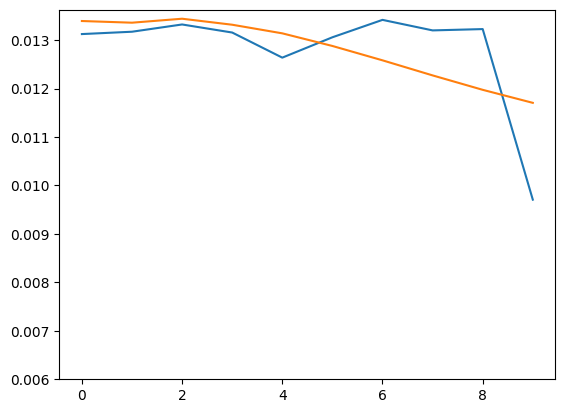

In [26]:

plt.plot(x, vdata1,label = 'actual')
plt.plot(x,future, label = 'prediction')
plt.ylim(0.006)
plt.show()


In [27]:
future

[array([0.01339445], dtype=float32),
 array([0.01335989], dtype=float32),
 array([0.01344175], dtype=float32),
 array([0.01331789], dtype=float32),
 array([0.01313997], dtype=float32),
 array([0.0128795], dtype=float32),
 array([0.01258306], dtype=float32),
 array([0.01227197], dtype=float32),
 array([0.01197435], dtype=float32),
 array([0.01170558], dtype=float32)]

In [28]:
import numpy as np

def calculate_errors(true_values, predicted_values):
    # 计算均方误差 (MSE)
    mse = np.mean((true_values - predicted_values) ** 2)
    
    # 计算均方根误差 (RMSE)
    rmse = np.sqrt(mse)
    
    # 计算平均绝对误差 (MAE)
    mae = np.mean(np.abs(true_values - predicted_values))
    
    # 计算标准化均方误差 (NMSE)
    nmse = np.mean((true_values - predicted_values) ** 2) / np.mean(true_values ** 2)
    
    return mse, rmse, mae, nmse

# 用法示例


mse, rmse, mae, nmse = calculate_errors(np.array(vdata), np.array(future))

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("NMSE:", nmse)

MSE: 1.4702531990420136e-06
RMSE: 0.0012125399783273184
MAE: 0.0008032672471247185
NMSE: 0.008909601511203511


In [29]:
mse1, rmse1, mae1, nmse1 = calculate_errors(np.array(vdata), np.array(baseline))
print("MSE:", mse1)
print("RMSE:", rmse1)
print("MAE:", mae1)
print("NMSE:", nmse1)

MSE: 4.799366325982477e-06
RMSE: 0.002190745609600183
MAE: 0.00215721428378823
NMSE: 0.029083726189920577


In [30]:
mse2, rmse2, mae2, nmse2 = calculate_errors(np.array(vdata), np.array(another))
print("MSE:", mse2)
print("RMSE:", rmse2)
print("MAE:", mae2)
print("NMSE:", nmse2)

MSE: 3.1157749402606147e-06
RMSE: 0.0017651557835671656
MAE: 0.001487465627045663
NMSE: 0.018881314548000336


In [31]:
vdata

[0.0131249137493579,
 0.0131734367994909,
 0.0133231769246612,
 0.013156793054789,
 0.0126385949414669,
 0.0130586776470181,
 0.013418074104675,
 0.0132007863364994,
 0.0132278527594622,
 0.0097074134795383]

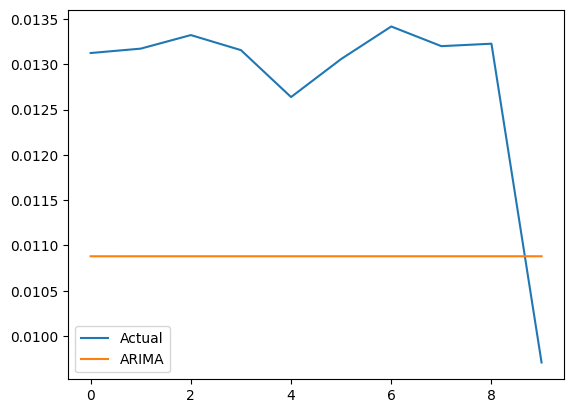

In [33]:
plt.plot(x,vdata, label = 'Actual')
plt.plot(x,baseline,label = 'ARIMA')
plt.legend()
plt.show()